# Customer Clustering

A project to practice customer segmentation and to learn new clustering techniques

## Load packages

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from utils import normalize

## Loading Data

In [2]:
customers = pd.read_csv('data/customers.csv')
orders = pd.read_csv('data/orders.csv')
products = pd.read_csv('data/products.csv')
sales = pd.read_csv('data/sales.csv')

## EDA

In [3]:
customers.head()

,customer_id,customer_name,gender,age,home_address,zip_code,city,state,country
0,1,Leanna Busson,Female,30,8606 Victoria TerraceSuite 560,5464,Johnstonhaven,Northern Territory,Australia
1,2,Zabrina Harrowsmith,Genderfluid,69,8327 Kirlin SummitApt. 461,8223,New Zacharyfort,South Australia,Australia
2,3,Shina Dullaghan,Polygender,59,269 Gemma SummitSuite 109,5661,Aliburgh,Australian Capital Territory,Australia
3,4,Hewet McVitie,Bigender,67,743 Bailey GroveSuite 141,1729,South Justinhaven,Queensland,Australia
4,5,Rubia Ashleigh,Polygender,30,48 Hyatt ManorSuite 375,4032,Griffithsshire,Queensland,Australia


In [4]:
customers.shape

(1000, 9)

In [5]:
orders.head()

,order_id,customer_id,payment,order_date,delivery_date
0,1,64,30811,2021-8-30,2021-09-24
1,2,473,50490,2021-2-3,2021-02-13
2,3,774,46763,2021-10-8,2021-11-03
3,4,433,39782,2021-5-6,2021-05-19
4,5,441,14719,2021-3-23,2021-03-24


In [6]:
orders.shape

(1000, 5)

In [7]:
print(len(orders['customer_id'].unique()))

617


In [8]:
products.head()

,product_ID,product_type,product_name,size,colour,price,quantity,description
0,0,Shirt,Oxford Cloth,XS,red,114,66,"A red coloured, XS sized, Oxford Cloth Shirt"
1,1,Shirt,Oxford Cloth,S,red,114,53,"A red coloured, S sized, Oxford Cloth Shirt"
2,2,Shirt,Oxford Cloth,M,red,114,54,"A red coloured, M sized, Oxford Cloth Shirt"
3,3,Shirt,Oxford Cloth,L,red,114,69,"A red coloured, L sized, Oxford Cloth Shirt"
4,4,Shirt,Oxford Cloth,XL,red,114,47,"A red coloured, XL sized, Oxford Cloth Shirt"


In [9]:
products.shape

(1260, 8)

In [10]:
sales.head()

,sales_id,order_id,product_id,price_per_unit,quantity,total_price
0,0,1,218,106,2,212
1,1,1,481,118,1,118
2,2,1,2,96,3,288
3,3,1,1002,106,2,212
4,4,1,691,113,3,339


In [11]:
sales.shape

(5000, 6)

## Aggregating data to customer level

### Aggregate data to order level

In [12]:
visits = pd.merge(orders, sales, on='order_id', how='inner').groupby('order_id', as_index=False).agg({'total_price': 'sum', 'quantity': 'sum', 'customer_id': 'first'})

In [13]:
visits.head()

,order_id,total_price,quantity,customer_id
0,1,1487,14,64
1,2,1130,11,473
2,3,508,5,774
3,4,976,10,433
4,5,2043,20,441


### Aggregate orders to customer level

In [14]:
custs = visits.groupby('customer_id', as_index=False).agg({'total_price': 'mean', 'quantity': 'mean', 'order_id': 'count'})
custs.head()

,customer_id,total_price,quantity,order_id
0,1,547.0,5.666667,3
1,7,1017.0,9.000000,1
2,10,270.0,3.000000,1
3,11,382.0,4.000000,1
4,12,1551.0,15.000000,1


In [15]:
custs.columns = ['customer_id', 'avg_spend', 'avg_basket_size', 'visits']
custs['total_spend'] = custs['avg_spend'] * custs['visits']
custs['total_units'] = custs['avg_basket_size'] * custs['visits']
custs.head()

,customer_id,avg_spend,avg_basket_size,visits,total_spend,total_units
0,1,547.0,5.666667,3,1641.0,17.0
1,7,1017.0,9.000000,1,1017.0,9.0
2,10,270.0,3.000000,1,270.0,3.0
3,11,382.0,4.000000,1,382.0,4.0
4,12,1551.0,15.000000,1,1551.0,15.0


In [16]:
custs_std = normalize(custs)

In [17]:
custs_std.head()

,customer_id,avg_spend,avg_basket_size,visits,total_spend,total_units
0,1,-1.156203,-1.071262,1.625746,-0.031784,0.080497
1,7,-0.065233,-0.264862,-0.716849,-0.615112,-0.697321
2,10,-1.799179,-1.716383,-0.716849,-1.313423,-1.280685
3,11,-1.539203,-1.474463,-0.716849,-1.208723,-1.183458
4,12,1.174295,1.186659,-0.716849,-0.115918,-0.113958


## Apply Clustering

### Tune parameters

In [18]:
best_eps = 0
best_min_samples = 0
best_score = -1

X = custs_std.drop("customer_id", axis=1)

for eps_val in np.arange(0.05, 1.0, 0.05):
    for min_samples_val in range(2, 10):
        dbscan = DBSCAN(eps=eps_val, min_samples=min_samples_val)
        labels = dbscan.fit_predict(X)

        # Calculate silhouette score, handling cases with single or no clusters
        if len(set(labels)) > 1: # Silhouette score requires at least two clusters
            score = silhouette_score(X, labels)
            if score > best_score:
                best_score = score
                best_eps = eps_val
                best_min_samples = min_samples_val

print(f"Best eps: {best_eps}, Best min_samples: {best_min_samples}, Best silhouette score: {best_score}")

Best eps: 0.15000000000000002, Best min_samples: 2, Best silhouette score: 0.5214756824753085


### Fit optimal model

In [19]:
clusters = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(X)
custs_std['cluster'] = clusters.labels_
custs_std.head()

,customer_id,avg_spend,avg_basket_size,visits,total_spend,total_units,cluster
0,1,-1.156203,-1.071262,1.625746,-0.031784,0.080497,0
1,7,-0.065233,-0.264862,-0.716849,-0.615112,-0.697321,1
2,10,-1.799179,-1.716383,-0.716849,-1.313423,-1.280685,2
3,11,-1.539203,-1.474463,-0.716849,-1.208723,-1.183458,3
4,12,1.174295,1.186659,-0.716849,-0.115918,-0.113958,4


In [20]:
custs_std.groupby('cluster').agg({'customer_id': 'count'})

,customer_id
cluster,
-1,36
0,3
1,25
2,10
3,16
...,...
55,5
56,3
57,4


A lot of smaller clusters, which isn't as helpful--increase eps and min_samples

In [21]:
clusters = DBSCAN(eps=0.5, min_samples=10).fit(X)
custs_std['cluster'] = clusters.labels_
custs_std.head()

,customer_id,avg_spend,avg_basket_size,visits,total_spend,total_units,cluster
0,1,-1.156203,-1.071262,1.625746,-0.031784,0.080497,2
1,7,-0.065233,-0.264862,-0.716849,-0.615112,-0.697321,0
2,10,-1.799179,-1.716383,-0.716849,-1.313423,-1.280685,0
3,11,-1.539203,-1.474463,-0.716849,-1.208723,-1.183458,0
4,12,1.174295,1.186659,-0.716849,-0.115918,-0.113958,0


In [22]:
custs_std.groupby('cluster').agg({'customer_id': 'count'})

,customer_id
cluster,
-1,33
0,354
1,159
2,70


## Visualize Cluster Relationships with Variables

/tmp/ipykernel_181263/1188143448.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(uniq)) # Choose a colormap
/tmp/ipykernel_181263/1188143448.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(custs_std['avg_spend'][indx], custs_std['visits'][indx], c=colors(i), label=uniq[i])


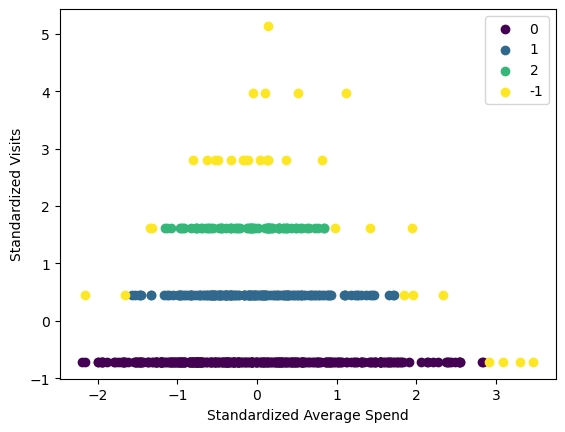

In [31]:
# Get unique names of species
uniq = list(set(custs_std['cluster']))

# Set the color map to match the number of species
z = range(1,len(uniq))
colors = plt.cm.get_cmap('viridis', len(uniq)) # Choose a colormap

for i in range(len(uniq)):
    indx = custs_std['cluster'] == uniq[i]
    plt.scatter(custs_std['avg_spend'][indx], custs_std['visits'][indx], c=colors(i), label=uniq[i])

plt.xlabel('Standardized Average Spend')
plt.ylabel('Standardized Visits')
plt.legend()
plt.show()

Clusters seem to be determined by visits primarily (likely due to small sample size)

/tmp/ipykernel_181263/4167661072.py:3: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(custs_std['avg_spend'][indx], custs_std['avg_basket_size'][indx], c=colors(i), label=uniq[i])


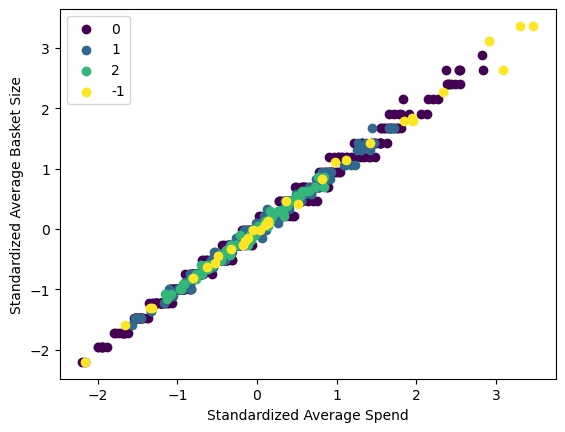

In [33]:
for i in range(len(uniq)):
    indx = custs_std['cluster'] == uniq[i]
    plt.scatter(custs_std['avg_spend'][indx], custs_std['avg_basket_size'][indx], c=colors(i), label=uniq[i])

plt.xlabel('Standardized Average Spend')
plt.ylabel('Standardized Average Basket Size')
plt.legend()
plt.show()

Can't tell much from average basket size

/tmp/ipykernel_181263/3856835943.py:3: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(custs_std['total_spend'][indx], custs_std['total_units'][indx], c=colors(i), label=uniq[i])


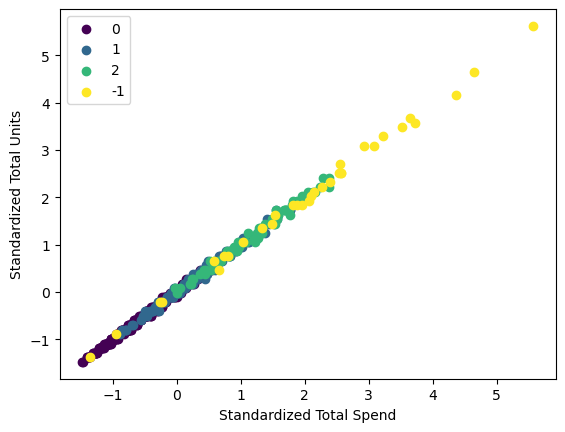

In [36]:
for i in range(len(uniq)):
    indx = custs_std['cluster'] == uniq[i]
    plt.scatter(custs_std['total_spend'][indx], custs_std['total_units'][indx], c=colors(i), label=uniq[i])

plt.xlabel('Standardized Total Spend')
plt.ylabel('Standardized Total Units')
plt.legend()
plt.show()

Total spend seems to somewhat delineate clusters as well (which makes sense, if visits is the key differentiator)

/tmp/ipykernel_181263/337591667.py:3: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(custs_std['total_spend'][indx], custs_std['visits'][indx], c=colors(i), label=uniq[i])


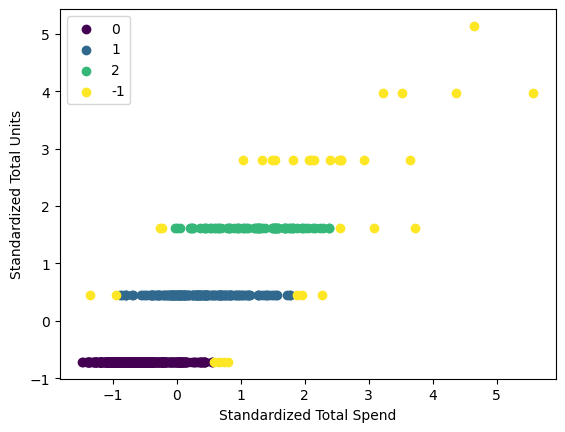

In [ ]:
for i in range(len(uniq)):
    indx = custs_std['cluster'] == uniq[i]
    plt.scatter(custs_std['total_spend'][indx], custs_std['visits'][indx], c=colors(i), label=uniq[i])

plt.xlabel('Standardized Total Spend')
plt.ylabel('Standardized Visits')
plt.legend()
plt.show()

So, final conclusions: Visits are primary indicator for clusters, with there being a range of "acceptable" total spends for each number of visits